In [1]:
import pickle
import json
import os
import sys
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import skimage
import tifffile
import yaml

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

In [7]:
run_dir = '/data/estorrs/mushroom/data/projects/submission_v1'

In [8]:
def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [9]:
dirs = [os.path.join(run_dir, root)
        for root in os.listdir(run_dir)
        if root not in ['lightsheet', 'kidney']]
dirs = sorted(dirs)
[x.split('/')[-1] for x in dirs]


['C3L-00970',
 'C3L-00982',
 'C3L-01287',
 'C3L-02551',
 'HT206B1',
 'HT225C1',
 'HT268B1',
 'HT339B2-H1',
 'HT397B1',
 'HT413C1-K2',
 'HT413C1-Th1k4A1',
 'HT448C1-Th1K1Fp1',
 'HT553P1-H2',
 'HT565B1-H2',
 'S18-25943-A7',
 'S18-5591-C8',
 'S18-9906',
 'WD-76845',
 'analysis']

In [10]:
# fix issues where antibody names aren't consistent accross some images
channel_to_idents = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'PanCK', 'PanCytokeratin'],
    'E-cadherin': ['E-cadherin', 'E-Cadherin'],
    'CD45': ['CD45'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin', 'Vim', 'VIM'],
    'SMA': ['SMA', 'a-SMA'],
    'CD31': ['CD31'],
    'CD20': ['CD20', 'CD20-Akoya'],
    'CD68': ['CD68'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKit', 'cKIT', 'ckit-(D)', 'ckit'],
    'MGP': ['MGP'],
    'CD36': ['CD36'],
    'PR': ['PR'],
    'ER': ['ER'],
    'P21': ['P21'],
    'P16': ['P16'],
    'CK5': ['Keratin 5', 'KRT5', 'CK5'],
    'CK7': ['CK7'],
    'CK8/18': ['CK8/18'],
    'TFF1': ['TFF1'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'KRT14'],
    'CK17': ['CK17', 'Keratin 17', 'CK17'],
    'CK19': ['CK19', 'Keratin 19', 'KRT19'],
    'CD11b': ['CD11b', 'CD11B', 'cd11b'],
    'GATA3': ['GATA3'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT'],
    'COX6c': ['COX6c', 'COX6C (D)', 'COX6C'],
    'Her2': ['Her2', 'HER2'],
    'Bap1': ['Bap1', 'BAP1'],
    'GLUT1': ['Glut1', 'GLUT1'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR', 'HLADR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN'],
    'CTLA4': ['CTLA4'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3'],
    'PTPRZ1': ['PTPRZ1'],
    'HIF1A': ['HIF1a', 'HIF1A'],
    'PAI1': ['PAI1'],
    'GFAP': ['GFAP'],
    'VEGFA': ['VEGFA'],
    'IBA1': ['IBA1'],
    'OLIG2': ['OLIG2'],
    'FN1': ['FN1'],
    'a-Amylase': ['a-Amylase', 'Amylase (D', 'Amylase'],
    'Hep-Par-1': ['Hep-Par-1', 'HepPar1-(D)', 'HepPar1'],
    'Granzyme-B': ['Granzyme B', 'GZMB'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1', 'PD1'],
    'PDL1': ['PD-L1', 'PDL1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63', 'p63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1', 'LYVE1'],
    'CCL2': ['CCL2'],
    'MUC2': ['MUC2'],
    'SOX9': ['SOX9'],
    'STEAP4': ['STEAP4'],
    'AR': ['AR'],
    'AMACR': ['AMACR'],
    'PGC': ['PGC', 'PGC (D)'],
    'CFTR': ['CFTR (D)', 'CFTR'],
    'REG3A': ['REG3A (D)', 'REG3A'],
    'LAMC2': ['LAMC2 (D)', 'LAMC2'],
    'INS': ['INS (D)', 'INS'],
    'CRP': ['CRP (D)', 'CRP'],
    'CD74': ['CD74 (D)', 'CD74'],
    'MUC5AC': ['MUC5AC (D)', 'MUC5AC'],
    'AQP1': ['AQP1'],
    'AQP2': ['Aqp2', 'AQP2'], 
    'LRP2': ['LRP2'],
    'UMOD': ['UMOD'],
    'CALB1': ['CALB1'],
    'CP': ['CP'],
    'CA9': ['CA9'],
    'UCHL1': ['UCHL1'],
}
channel_mapping = {v:k for k, vs in channel_to_idents.items() for v in vs}

# add in (D) variants
variants = ['(D)', ' (D)', '(d)', ' (d)', '-(D)', '-(d)', ' (Dnew)', '(Dnew)', '-(Dnew)']
channel_mapping.update({k + variant:v
                      for k, v in channel_mapping.items()
                      for variant in variants})

In [11]:
case = 'HT206B1'
target_res = 50
metadata = yaml.safe_load(open(os.path.join(run_dir, case, 'registered', 'metadata.yaml')))

config = deepcopy(DEFAULT_CONFIG)

#         mask_fp = os.path.join(run_dir, case, 'masks', 'tissue_mask.tif')
#         if not os.path.exists(mask_fp):
#             mask_fp = None
mask_fp = None # running without masks

config = utils.recursive_update(config, {
    'sections': metadata['sections'],
    'trainer_kwargs': {
        'input_resolution': metadata['resolution'],
        'target_resolution': target_res,
        'out_dir': os.path.join(run_dir, case, f'mushroom_test'),
        'accelerator': 'gpu',
#                 'steps_per_epoch': n_steps, setting later for each dtype
        'data_mask': mask_fp,
    }
})

config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
    'visium': {
        'trainer_kwargs': {
            'target_resolution': 100  # lower resolution for visium
        }
    },
    'multiplex': {
        'trainer_kwargs': {
            'channel_mapping': channel_mapping
        }
    }
})

dtypes = set([mapping['dtype'] for entry in metadata['sections'] for mapping in entry['data']])
for dtype in dtypes:
    n_sections = len([mapping
                      for entry in metadata['sections']
                      for mapping in entry['data']
                      if mapping['dtype'] == dtype])

    config['dtype_specific_params'] = utils.recursive_update(config['dtype_specific_params'], {
        dtype: {
            'trainer_kwargs': {
                'steps_per_epoch': 1000
            }
        }
    })

config = alter_filesystem(config, source_root, target_root)


In [17]:
config['sae_kwargs']['neigh_scaler'] = 0.
config['sae_kwargs']['neigh_scaler'] = .01

In [18]:
config

{'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s0_HT206B1-U1_xenium.h5ad'}],
   'position': 0,
   'sid': 'HT206B1-U1'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s1_HT206B1-U2_multiplex.ome.tiff'}],
   'position': 5,
   'sid': 'HT206B1-U2'},
  {'data': [{'dtype': 'he',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s2_HT206B1-U4_he.tif'}],
   'position': 15,
   'sid': 'HT206B1-U4'},
  {'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s3_HT206B1-U5_multiplex.ome.tiff'}],
   'position': 20,
   'sid': 'HT206B1-U5'},
  {'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/HT206B1/registered/s4_HT206B1-U8_xenium.h5ad'}],
   'position': 40,
   'sid': 'HT206B1-U8'},
  {'data'

In [19]:

dtype_to_weight = {
    'he': 0.,
    'xenium': 1.,
    'multiplex': 1.
}
    
mushroom = Mushroom.from_config(config)
print(mushroom.section_ids)

mushroom.train()
mushroom.embed_sections()

INFO:root:loading spore for he
INFO:root:data mask detected
INFO:root:starting he processing
INFO:root:3 sections detected: ['HT206B1-U4', 'HT206B1-U12', 'HT206B1-U20']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U4


0.02


INFO:root:generating image data for section HT206B1-U12
INFO:root:generating image data for section HT206B1-U20
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 3 sections detected: [('HT206B1-U4', 'he'), ('HT206B1-U12', 'he'), ('HT206B1-U20', 'he')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for multiplex
INFO:root:data mask detected
INFO:root:starting multiplex processing
INFO:root:using 36 channels
INFO:root:6 sections detected: ['HT206B1-U2', 'HT206B1-U5', 'HT206B1-U10', 'HT206B1-U13', 'HT206B1-U18', 'HT206B1-U21']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U2


he torch.Size([3, 130, 121])
0.02


INFO:root:generating image data for section HT206B1-U5
INFO:root:generating image data for section HT206B1-U10
INFO:root:generating image data for section HT206B1-U13
INFO:root:generating image data for section HT206B1-U18
INFO:root:generating image data for section HT206B1-U21
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U2', 'multiplex'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U21', 'multiplex')]
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:loading spore for xenium
INFO:root:data mask detected
INFO:root:starting xenium processing


multiplex torch.Size([36, 130, 121])


INFO:root:using 377 channels
INFO:root:6 sections detected: ['HT206B1-U1', 'HT206B1-U8', 'HT206B1-U9', 'HT206B1-U16', 'HT206B1-U17', 'HT206B1-U24']
INFO:root:processing sections
INFO:root:generating image data for section HT206B1-U1
INFO:root:generating image data for section HT206B1-U8
INFO:root:generating image data for section HT206B1-U9
INFO:root:generating image data for section HT206B1-U16
INFO:root:generating image data for section HT206B1-U17
INFO:root:generating image data for section HT206B1-U24
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:total of 6 sections detected: [('HT206B1-U1', 'xenium'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U24', 'xenium')]


xenium torch.Size([377, 131, 122])


INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:model initialized
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
INFO:root:starting training for he
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/he_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.869    Total estimated model params size (MB)


[('HT206B1-U1', 'xenium'), ('HT206B1-U2', 'multiplex'), ('HT206B1-U4', 'he'), ('HT206B1-U5', 'multiplex'), ('HT206B1-U8', 'xenium'), ('HT206B1-U9', 'xenium'), ('HT206B1-U10', 'multiplex'), ('HT206B1-U12', 'he'), ('HT206B1-U13', 'multiplex'), ('HT206B1-U16', 'xenium'), ('HT206B1-U17', 'xenium'), ('HT206B1-U18', 'multiplex'), ('HT206B1-U20', 'he'), ('HT206B1-U21', 'multiplex'), ('HT206B1-U24', 'xenium')]


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training he, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/he_chkpts/last-v2.ckpt
INFO:root:starting training for multiplex
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/multiplex_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.0 M 
------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.924    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training multiplex, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/multiplex_chkpts/last-v1.ckpt
INFO:root:starting training for xenium
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/xenium_chkpts exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name | Type | Params
------------------------------
0 | sae  | SAE  | 5.2 M 
------------------------------
5.2 M     Trainable params
0         Non-trainable params
5.2 M     Total params
20.839    Total estimated model params size (MB)


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:root:finished training xenium, saved chkpt to /data/estorrs/mushroom/data/projects/submission_v1/HT206B1/mushroom_test/xenium_chkpts/last-v1.ckpt
INFO:root:embedding he spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

INFO:root:embedding multiplex spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

INFO:root:embedding xenium spore
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting: |                                                                                                 …

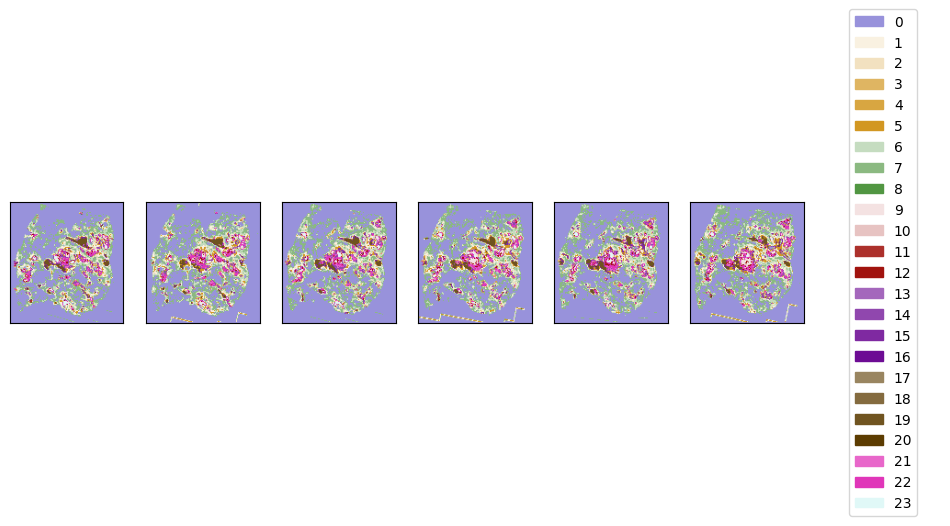

In [15]:
mushroom.display_clusters('multiplex')

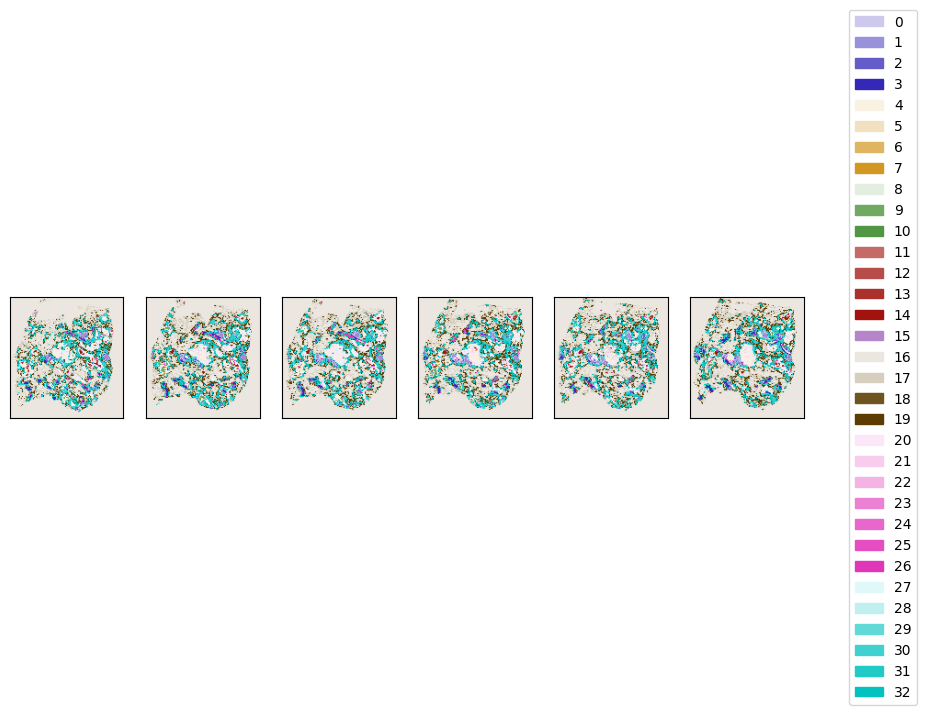

In [16]:
mushroom.display_clusters('xenium')

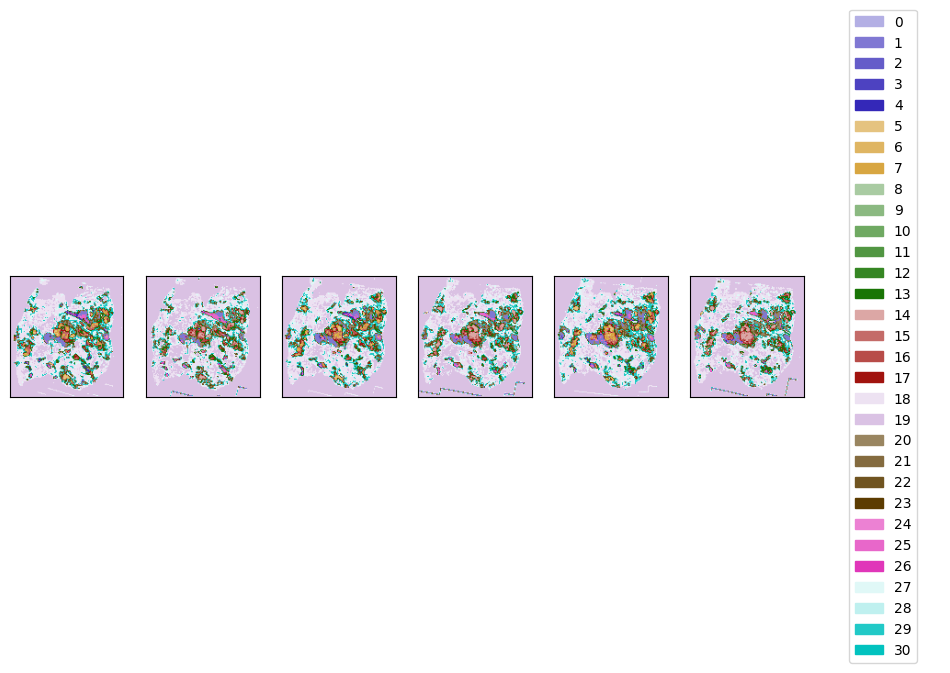

In [20]:
mushroom.display_clusters('multiplex')

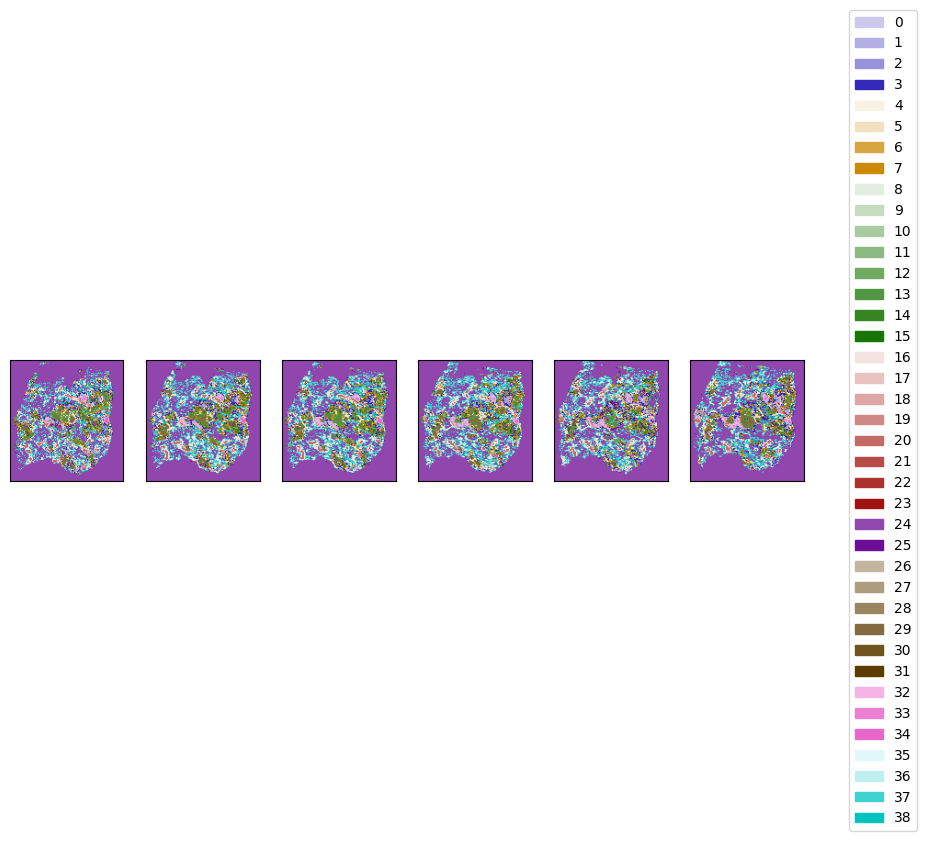

In [21]:
mushroom.display_clusters('xenium')